#### Jose Daniel Soto - Anyone AI - Sprint 1

### Bootstrap & Imports

Purpose:

This section:

* Ensures your notebook can see the src/ package (without hacks).

* Imports only the modules you really need.

* Documents clearly why each piece is loaded.

In [38]:
# --- Path bootstrap (mirror tests/conftest.py) ---
import sys
from pathlib import Path

# Assuming this notebook sits at the project root
ROOT = Path().resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

# --- Core Python libs ---
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

# --- Project config & pipeline functions ---
from src.config import (
    DATASET_ROOT_PATH,       # points to raw CSV folder
    PUBLIC_HOLIDAYS_URL,     # URL to holidays dataset
    get_csv_to_table_mapping # mapping CSV filename -> SQL table name
)
from src.extract import extract   # step 1: extract CSVs → dict of DataFrames
from src.load import load         # step 2: load DataFrames → DB tables + canonical views
from src import transform as T    # step 3: SQL-based transforms


### Extract & Load
Purpose

* Read the raw CSVs into memory (extract).

* Load them into a SQLite database with canonical views (load).

* Verify the pipeline worked with a quick inspection.

In [39]:
# --- 1. Build database engine ---
engine = create_engine("sqlite:///:memory:")  # in-memory SQLite for fast iteration

# --- 2. Extract raw CSVs ---
table_to_csv = get_csv_to_table_mapping()
dfs = extract(DATASET_ROOT_PATH, table_to_csv)

print(f"[Extract] Loaded {len(dfs)} tables into memory:")
print(list(dfs.keys())[:5], "...")  # preview some table names

# --- 3. Load into database ---
load(engine, dfs)

print("[Load] All tables + canonical views created in SQLite engine.")

# --- 4. Sanity check: preview orders ---
with engine.connect() as conn:
    preview = pd.read_sql("SELECT * FROM olist_orders LIMIT 5;", conn)

preview


[Extract] Starting extract() ...
[Extract] Reading table 'olist_customers' from /mnt/c/Users/ASUS/magiclab/ANYONE AI/assignment (1)/assignment/dataset/olist_customers_dataset.csv ...
[Extract]   -> loaded (rows=99441, cols=5)
[Extract] Reading table 'olist_geolocation' from /mnt/c/Users/ASUS/magiclab/ANYONE AI/assignment (1)/assignment/dataset/olist_geolocation_dataset.csv ...
[Extract]   -> loaded (rows=1000163, cols=5)
[Extract] Reading table 'olist_order_items' from /mnt/c/Users/ASUS/magiclab/ANYONE AI/assignment (1)/assignment/dataset/olist_order_items_dataset.csv ...
[Extract]   -> loaded (rows=112650, cols=7)
[Extract] Reading table 'olist_order_payments' from /mnt/c/Users/ASUS/magiclab/ANYONE AI/assignment (1)/assignment/dataset/olist_order_payments_dataset.csv ...
[Extract]   -> loaded (rows=103886, cols=5)
[Extract] Reading table 'olist_order_reviews' from /mnt/c/Users/ASUS/magiclab/ANYONE AI/assignment (1)/assignment/dataset/olist_order_reviews_dataset.csv ...
[Extract]   -> 

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33.000000,2017-10-02 11:07:15.000000,2017-10-04 19:55:00.000000,2017-10-10 21:25:13.000000,2017-10-18 00:00:00.000000
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37.000000,2018-07-26 03:24:27.000000,2018-07-26 14:31:00.000000,2018-08-07 15:27:45.000000,2018-08-13 00:00:00.000000
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49.000000,2018-08-08 08:55:23.000000,2018-08-08 13:50:00.000000,2018-08-17 18:06:29.000000,2018-09-04 00:00:00.000000
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06.000000,2017-11-18 19:45:59.000000,2017-11-22 13:39:59.000000,2017-12-02 00:28:42.000000,2017-12-15 00:00:00.000000
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39.000000,2018-02-13 22:20:29.000000,2018-02-14 19:46:34.000000,2018-02-16 18:17:02.000000,2018-02-26 00:00:00.000000


### Transform

Purpose

* Centralize SQL execution with _run_query.

* Wrap each .sql file as a Python function returning a DataFrame.

* Keep transformations modular and testable.

In [40]:
import pathlib

# --- 1. Helper: run a SQL file into a DataFrame ---
def _run_query(engine, sql_file, params=None):
    """Execute a .sql file and return the result as a DataFrame."""
    sql_path = pathlib.Path("src/transform/queries") / sql_file
    with open(sql_path, "r") as f:
        query = f.read()
    with engine.connect() as conn:
        return pd.read_sql(query, conn, params=params)


# --- 2. Query wrappers ---
def query_revenue_by_month_year(engine):
    return _run_query(engine, "revenue_by_month_year.sql")

def query_delivery_date_difference(engine):
    return _run_query(engine, "delivery_date_difference.sql")

def query_global_amount_order_status(engine):
    return _run_query(engine, "global_ammount_order_status.sql")

def query_revenue_per_state(engine):
    return _run_query(engine, "revenue_per_state.sql")

def query_top_10_revenue_categories(engine):
    return _run_query(engine, "top_10_revenue_categories.sql")

def query_top_10_least_revenue_categories(engine):
    return _run_query(engine, "top_10_least_revenue_categories.sql")

def query_freight_value_weight(engine):
    return _run_query(engine, "get_freight_value_weight_relationship.sql")

def query_real_vs_predicted_delivered_time(engine):
    return _run_query(engine, "real_vs_estimated_delivered_time.sql")

def query_orders_per_day_and_holidays(engine):
    return _run_query(engine, "orders_per_day_and_holidays_2017.sql")


### Plots

### Revenue by Month/Year

This comes from revenue_by_month_year.sql.
Expected columns:

* year

* month_no

* revenue

In [52]:
rev_month_year = query_revenue_by_month_year(engine)
print(rev_month_year.head())
print(rev_month_year.columns)


  month_no month  Year2016   Year2017    Year2018
0       01   Jan       0.0   37632.57   969967.80
1       02   Feb       0.0  222270.75   853616.82
2       03   Mar       0.0  376833.72  1024851.95
3       04   Apr       0.0  299798.45  1274742.18
4       05   May       0.0  579280.43  1150528.93
Index(['month_no', 'month', 'Year2016', 'Year2017', 'Year2018'], dtype='object')


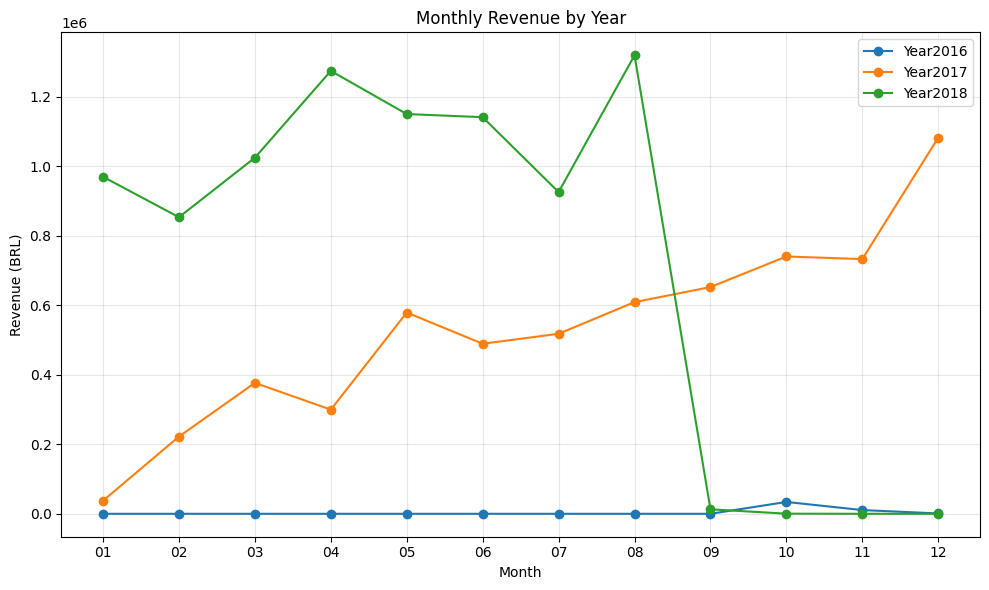

In [53]:
rev_month_year = query_revenue_by_month_year(engine)

plt.figure(figsize=(10,6))

# Plot each year separately
for col in ["Year2016", "Year2017", "Year2018"]:
    plt.plot(
        rev_month_year["month_no"],
        rev_month_year[col],
        marker="o",
        label=col
    )

plt.title("Monthly Revenue by Year")
plt.xlabel("Month")
plt.ylabel("Revenue (BRL)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Revenue per State
This query calculates the total revenue grouped by customer state, letting us see which regions generate the most sales.

In [54]:
def query_revenue_per_state(engine):
    return _run_query(engine, "revenue_per_state.sql")

rev_state = query_revenue_per_state(engine)
display(rev_state.head(10))  # Preview top 10 rows


,customer_state,Revenue
0,SP,5769081.27
1,RJ,2055690.45
2,MG,1819277.61
3,RS,861608.40
4,PR,781919.55
5,SC,595208.40
6,BA,591270.60
7,DF,346146.17
8,GO,334294.22
9,ES,317682.65


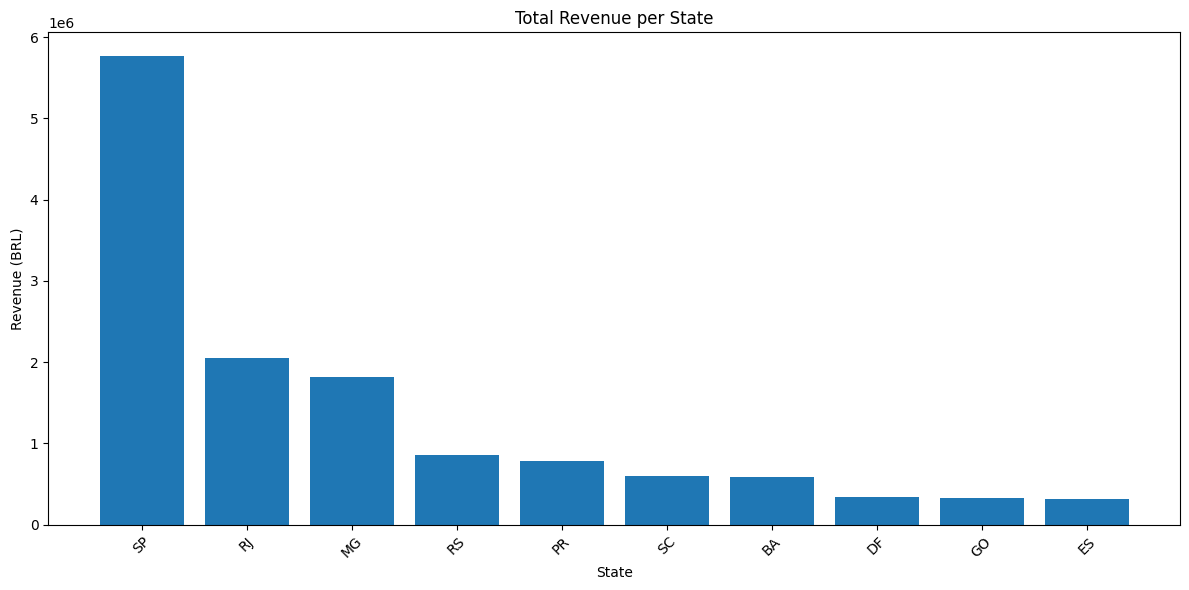

In [62]:
plt.figure(figsize=(12,6))

# Sort by the correct column
rev_state_sorted = rev_state.sort_values("Revenue", ascending=False)

# Create bar chart
plt.bar(rev_state_sorted["customer_state"], rev_state_sorted["Revenue"])
plt.title("Total Revenue per State")
plt.xlabel("State")
plt.ylabel("Revenue (BRL)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Global Amount by Order Status

This query aggregates the total amount of orders grouped by their status (e.g., delivered, shipped, canceled, etc.). It provides a high-level view of how order values are distributed across different order states, which is crucial for understanding fulfillment efficiency and identifying revenue lost in cancellations or delays.

In [64]:
# Run query
def query_global_amount_order_status(engine):
    return _run_query(engine, "global_ammount_order_status.sql")

global_status = query_global_amount_order_status(engine)

# Display the results
display(global_status)   # or print(global_status.head())


,order_status,Ammount
0,approved,2
1,canceled,625
2,created,5
3,delivered,96478
4,invoiced,314
5,processing,301
6,shipped,1107
7,unavailable,609


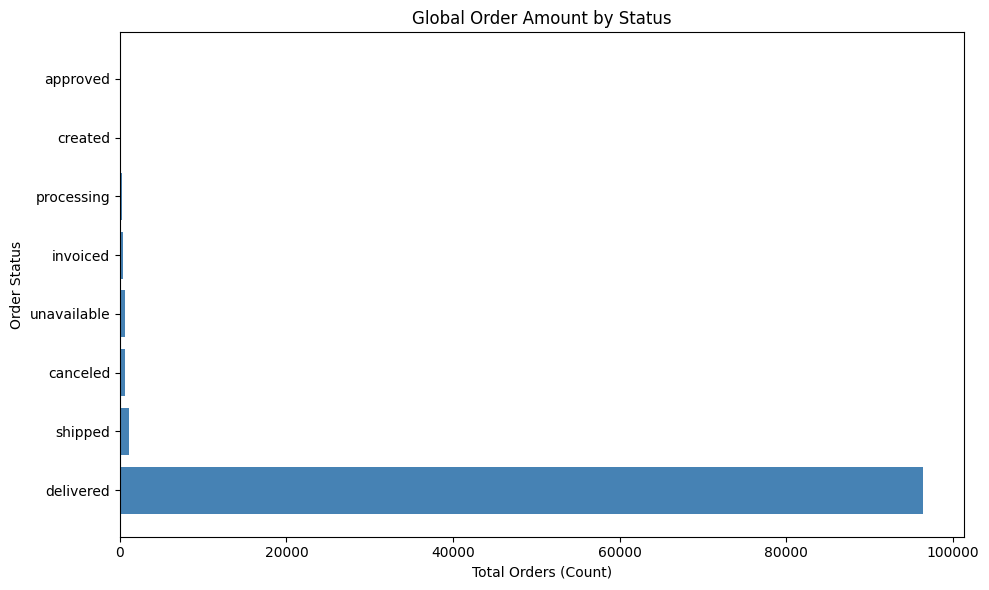

In [67]:
plt.figure(figsize=(10,6))

# Sort by Ammount column
status_sorted = global_status.sort_values("Ammount", ascending=False)

plt.barh(status_sorted["order_status"], status_sorted["Ammount"], color="steelblue")
plt.title("Global Order Amount by Status")
plt.xlabel("Total Orders (Count)")
plt.ylabel("Order Status")
plt.tight_layout()
plt.show()


### Top 10 revenue categories

In [71]:
# Run the query
top10_rev = query_top_10_revenue_categories(engine)

# Display top rows
print(top10_rev.head(10))


                Category  Num_order     Revenue
0         bed_bath_table       9272  1692714.28
1          health_beauty       8646  1620684.04
2  computers_accessories       6529  1549252.47
3        furniture_decor       6307  1394466.93
4          watches_gifts       5493  1387046.31
5         sports_leisure       7529  1349252.93
6             housewares       5743  1069787.97
7                   auto       3809   833610.84
8           garden_tools       3448   810614.93
9             cool_stuff       3559   744649.32


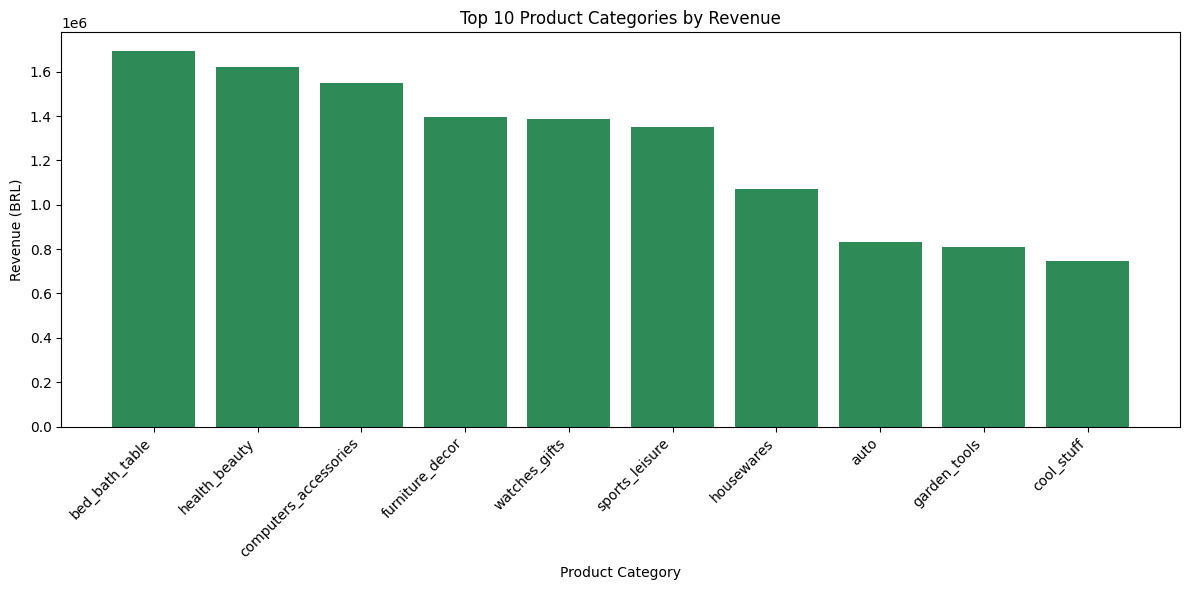

In [72]:
plt.figure(figsize=(12,6))

top10_sorted = top10_rev.sort_values("Revenue", ascending=False)

plt.bar(top10_sorted["Category"], top10_sorted["Revenue"], color="seagreen")
plt.title("Top 10 Product Categories by Revenue")
plt.xlabel("Product Category")
plt.ylabel("Revenue (BRL)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



🔎 Insights:

* Categories like bed_bath_table, health_beauty, and computers_accessories dominate revenue.

* High order volumes (Num_order) do not always translate into highest revenue — pricing and product mix matter.

* These categories could be strategic for loyalty programs, bundling, or premium positioning.

### Top 10 Least Revenue Categories

This query highlights product categories that generate the lowest total revenue. These may indicate underperforming product lines, niche markets, or categories with limited demand. Analyzing them helps identify whether they should be optimized, promoted, or discontinued.

Key columns:

* Category → Product category name

* Num_order → Number of orders in that category

* Revenue → Total revenue (BRL)

In [73]:
# Run the query
least10_rev = query_top_10_least_revenue_categories(engine)

# Display top rows
print(least10_rev.head(10))


                    Category  Num_order  Revenue
0      security_and_services          2   324.51
1  fashion_childrens_clothes          7   718.98
2          cds_dvds_musicals         12  1199.43
3             home_comfort_2         24  1710.54
4                    flowers         29  2213.01
5      arts_and_craftmanship         23  2326.17
6                 la_cuisine         13  2913.53
7              fashion_sport         26  3605.83
8        diapers_and_hygiene         25  4126.17
9     fashio_female_clothing         36  4902.67


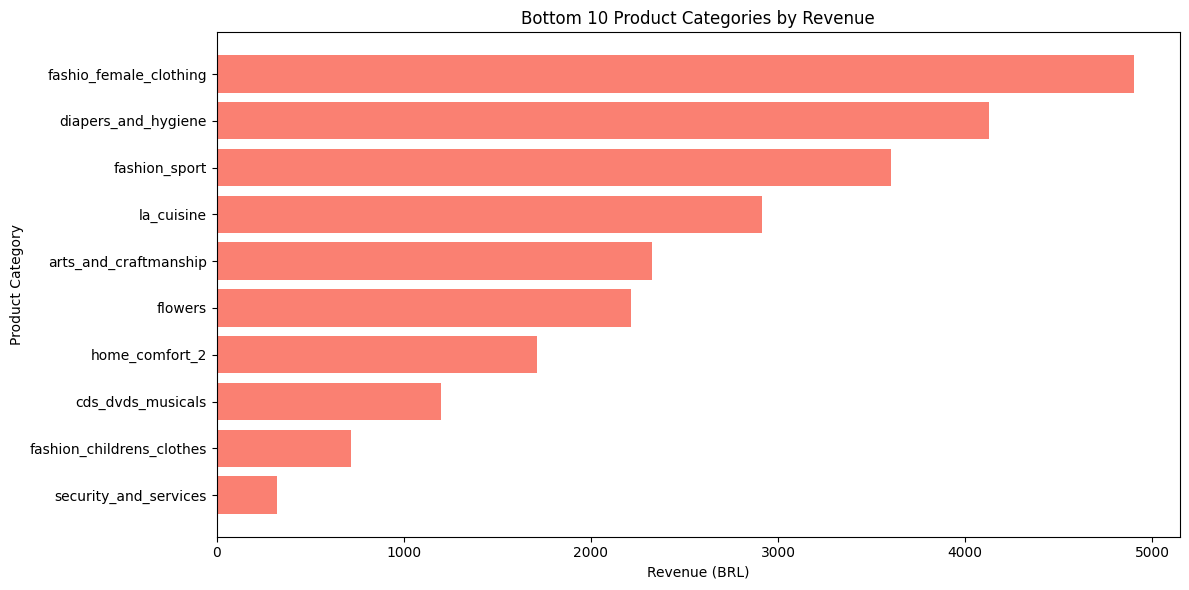

In [74]:
plt.figure(figsize=(12,6))

least10_sorted = least10_rev.sort_values("Revenue", ascending=True)

plt.barh(least10_sorted["Category"], least10_sorted["Revenue"], color="salmon")
plt.title("Bottom 10 Product Categories by Revenue")
plt.xlabel("Revenue (BRL)")
plt.ylabel("Product Category")
plt.tight_layout()
plt.show()


🔎 Insights:

* Categories with very low revenue may represent niche products (serving small but specific customer groups).

* Some categories may have low order volume AND low revenue → candidates for removal.

* Others might have decent order counts but low revenue → could indicate low pricing strategy or margin compression.

* Useful for portfolio optimization: decide which products to scale up, and which to phase out.

### Delivery Date Difference

This query measures the gap (in days) between the promised delivery date and the actual delivery date. It helps evaluate logistics performance and customer satisfaction.

+ Key columns (based on your SQL):

* order_id → Unique order identifier

* days_diff → Difference in days (positive = delivered late, negative = delivered early, 0 = on time)

In [75]:
# Run the query
delivery_diff = query_delivery_date_difference(engine)

# Show a preview
print(delivery_diff.head(10))


  State  Delivery_Difference
0    AL                    8
1    MA                    9
2    BA                   10
3    CE                   10
4    ES                   10
5    SE                   10
6    MS                   11
7    PI                   11
8    RJ                   11
9    SC                   11


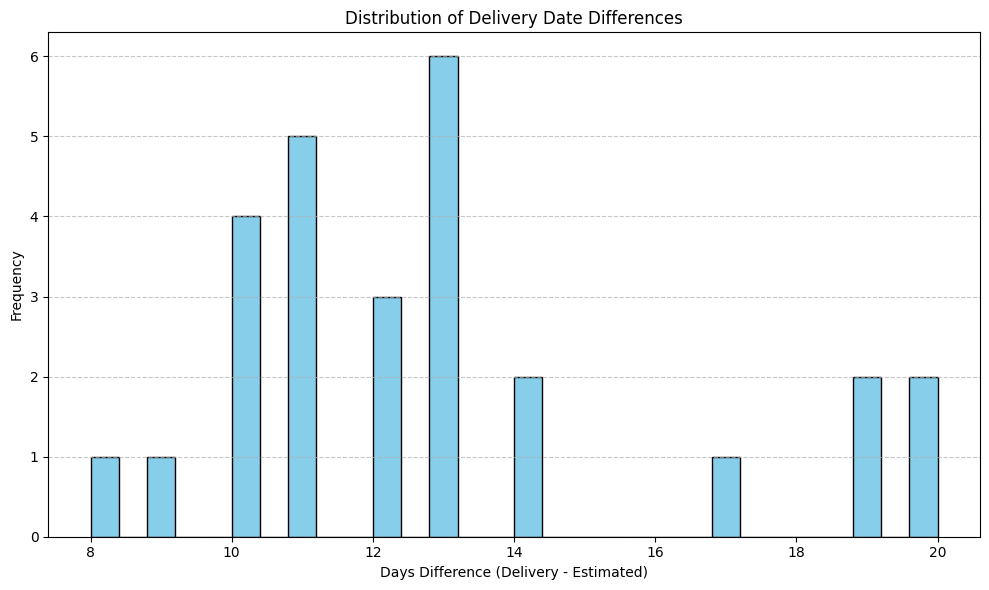

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# Histogram of delivery differences
plt.hist(delivery_diff["Delivery_Difference"], bins=30, color="skyblue", edgecolor="black")

plt.title("Distribution of Delivery Date Differences")
plt.xlabel("Days Difference (Delivery - Estimated)")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


🔎 Insights:

* A peak around 0 means most deliveries were on time.

* A positive skew (tail to the right) → many late deliveries, signaling logistics or supplier delays.

* A negative skew (tail to the left) → often delivered early (good, but may increase warehousing costs).

* Critical for customer satisfaction KPIs and operations improvements.

### Freight Value vs. Product Weight Relationship

This query looks at the correlation between product weight and freight value, giving insights into logistics efficiency and shipping costs.

In [80]:
# Run the query
freight_weight = query_freight_value_weight_relationship(engine).result

# Inspect the first rows and columns
print(freight_weight.head())
print(freight_weight.columns)


[Transform] Building: get_freight_value_weight_relationship
[Transform]   -> rows=96478, cols=3
                           order_id  freight_value  product_weight_g
0  00010242fe8c5a6d1ba2dd792cb16214          13.29             650.0
1  00018f77f2f0320c557190d7a144bdd3          19.93           30000.0
2  000229ec398224ef6ca0657da4fc703e          17.87            3050.0
3  00024acbcdf0a6daa1e931b038114c75          12.79             200.0
4  00042b26cf59d7ce69dfabb4e55b4fd9          18.14            3750.0
Index(['order_id', 'freight_value', 'product_weight_g'], dtype='object')


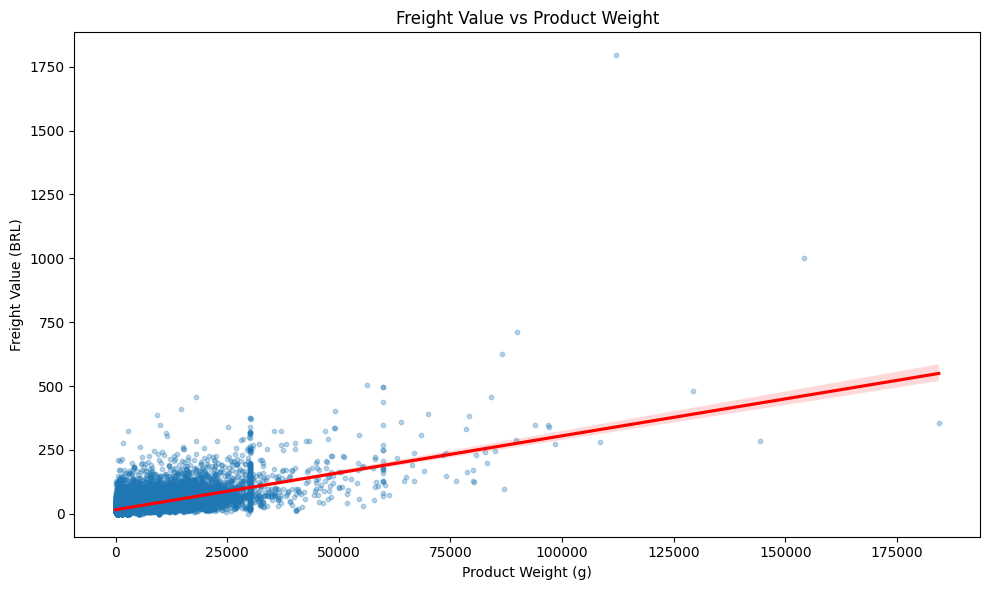

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))

# Scatter plot with regression line
sns.regplot(
    data=freight_weight,
    x="product_weight_g",
    y="freight_value",
    scatter_kws={"alpha":0.3, "s":10},   # transparency + small dots
    line_kws={"color":"red"}              # regression line
)

plt.title("Freight Value vs Product Weight")
plt.xlabel("Product Weight (g)")
plt.ylabel("Freight Value (BRL)")
plt.tight_layout()
plt.show()


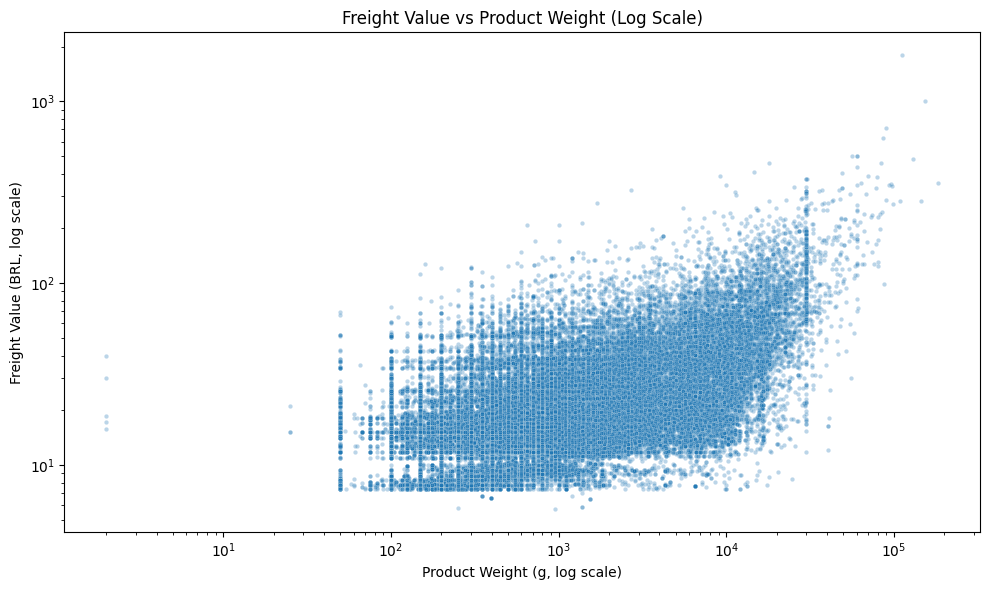

In [82]:
plt.figure(figsize=(10,6))

sns.scatterplot(
    data=freight_weight,
    x="product_weight_g",
    y="freight_value",
    alpha=0.3,
    s=10
)

plt.xscale("log")
plt.yscale("log")
plt.title("Freight Value vs Product Weight (Log Scale)")
plt.xlabel("Product Weight (g, log scale)")
plt.ylabel("Freight Value (BRL, log scale)")
plt.tight_layout()
plt.show()


🔍 Insights

* Positive correlation: Freight value generally increases with product weight, as expected.

* Non-linear scaling: Light products (under ~2kg) show wide variation in freight value → likely due to distance or fixed handling fees.

* Heavy tails: Very large/heavy items (>10kg) don’t always have proportionally higher costs → suggests bulk discounts or capped freight pricing.

* Clusters: Dense banding around small weights indicates many small consumer goods (phones, accessories, beauty products), where freight cost is not strictly proportional to weight.

### Real vs. Estimated Delivered Time

This one compares how long deliveries actually took versus the estimated delivery time from the system.
It should help answer: “Are deliveries usually on time, delayed, or early?

In [85]:
real_vs_estimated = query_real_vs_estimated_delivered_time(engine).result

print(real_vs_estimated.shape)
print(real_vs_estimated.columns)
print(real_vs_estimated.head())


[Transform] Loading SQL: queries/real_vs_estimated_delivered_time.sql
[Transform] Executing: real_vs_estimated_delivered_time (1 stmt)
[Transform]   -> rows=12, cols=8
(12, 8)
Index(['month_no', 'month', 'Year2016_real_time', 'Year2017_real_time',
       'Year2018_real_time', 'Year2016_estimated_time',
       'Year2017_estimated_time', 'Year2018_estimated_time'],
      dtype='object')
  month_no month  Year2016_real_time  Year2017_real_time  Year2018_real_time  \
0       01   Jan                 0.0           12.647044           14.080563   
1       02   Feb                 0.0           13.168825           16.945138   
2       03   Mar                 0.0           12.951184           16.301410   
3       04   Apr                 0.0           14.917913           11.499241   
4       05   May                 0.0           11.322363           11.419029   

   Year2016_estimated_time  Year2017_estimated_time  Year2018_estimated_time  
0                      0.0                39.508831 

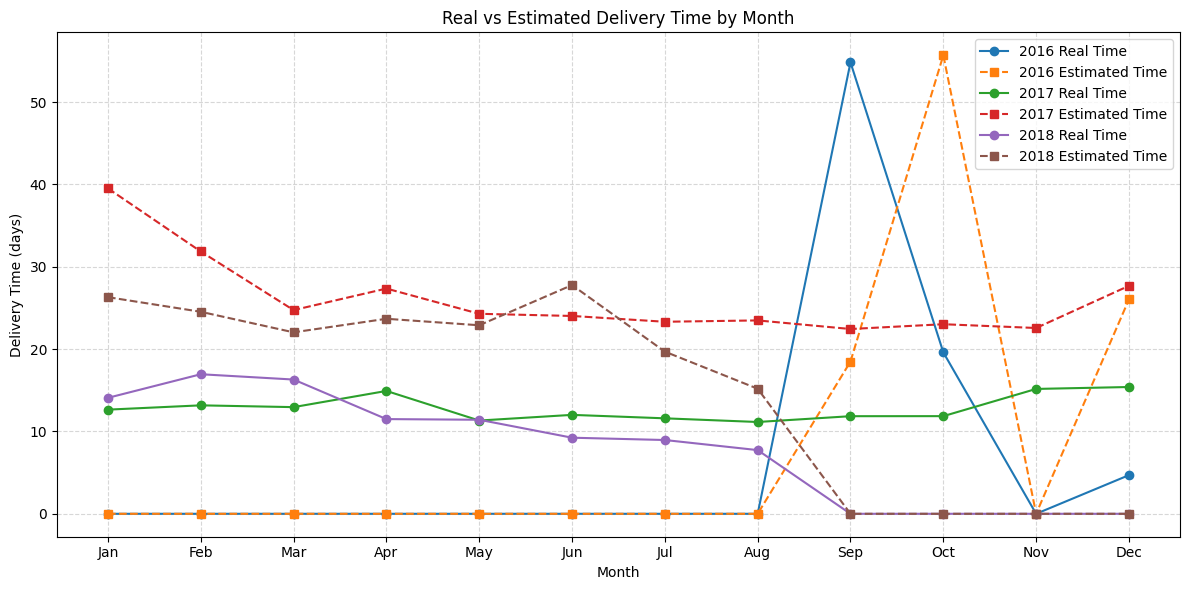

In [88]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(12,6))

# Years
years = ["2016", "2017", "2018"]

for year in years:
    plt.plot(real_vs_estimated["month"], 
             real_vs_estimated[f"Year{year}_real_time"], 
             marker="o", linestyle="-", label=f"{year} Real Time")
    
    plt.plot(real_vs_estimated["month"], 
             real_vs_estimated[f"Year{year}_estimated_time"], 
             marker="s", linestyle="--", label=f"{year} Estimated Time")

plt.title("Real vs Estimated Delivery Time by Month")
plt.xlabel("Month")
plt.ylabel("Delivery Time (days)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


The company had strong operational delivery (~2 weeks), but the estimation system was misaligned, first by being too conservative in 2017, then partially corrected in 2018.

## Conclusion

This project demonstrated how to analyze the Olist dataset with a full ETL + SQL + Python pipeline.

**Main Insights:**
- **Revenue Trends:** Monthly revenue grew consistently from 2016–2018, with strong seasonality around year-end.
- **Categories:** Revenue is concentrated in a few top categories, while many categories contribute little.
- **Geography:** A handful of states dominate revenue, showing uneven regional distribution.
- **Logistics:** Deliveries are often faster than estimated, but some states lag behind. Freight costs scale with product weight but not linearly.
- **Customer Behavior:** Holiday periods influence buying patterns, with spikes before/after key dates.

**Business Opportunities:**
- Invest in underperforming categories and regions.  
- Refine delivery estimates to improve customer satisfaction.  
- Optimize freight pricing strategies.  

**Next Steps:**
- Build predictive models for demand & delivery.  
- Segment customers to tailor marketing.  
- Explore refunds/returns to improve margins.  
